# Load functions and data

In [1]:
%run functions

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
loader = DataLoader()
d = loader.GetData('final')

In [3]:
topics = {
    '19121413':'dormitory',
    '19121416':'reading',
    '19121417':'English',
    '19121435':'friends',
    '19121436':'langauge',
    '19121437':'parents',
    '19121438':'fit',
    '19121439':'homesickness',
    '19121440':'books',
    '1000561535':'internet'
}

In [4]:
clean_text = []
preproc = preprocessing.make_pipeline(preprocessing.normalize.whitespace)
for essay in d['text']:
    for punct in [':',',','.','?',';',"'",'!']:
        essay = essay.replace(punct,punct+' ')
    cleaned = preproc(essay.replace('\n',''))
    clean_text.append(cleaned)
d['text'] = clean_text

In [5]:
sns.set_style('darkgrid')

In [11]:
token = []
with open('features/final-winter-fine.csv') as f:
    raw = f.readlines()[1:3831]
for i in range(len(raw)):
    l = raw[i]
    l = l.rstrip('\n').split(',')[2:]
    l = [float(i) for i in l]
    if  d['score'][i] > 0:
        token.append(l[-7])
    else:
        token.append(0)

In [12]:
d['token'] = token

#### Descriptive statistics

In [13]:
d = d.loc[d['score'] > 0,:]

In [14]:
sum(d['token'])

716911.0

In [15]:
d['token'].describe()

count    3784.00000
mean      189.45851
std        43.98006
min         5.00000
25%       162.00000
50%       183.00000
75%       209.00000
max       626.00000
Name: token, dtype: float64

In [16]:
d['score'].describe()

count    3784.000000
mean       10.120217
std         1.357051
min         0.100000
25%         9.600000
50%        10.300000
75%        11.000000
max        13.600000
Name: score, dtype: float64

<AxesSubplot: xlabel='score', ylabel='Count'>

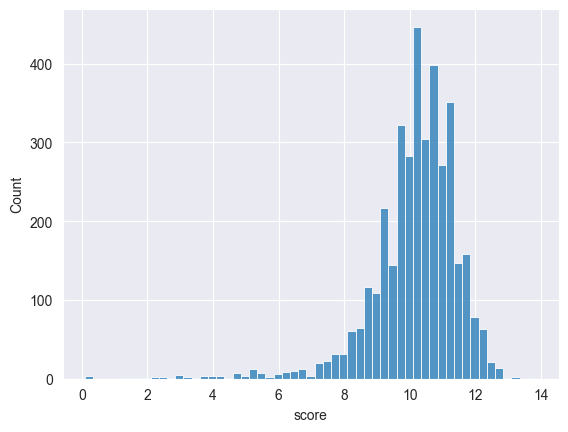

In [18]:
sns.histplot(d,x='score',binwidth=0.25)

<AxesSubplot: xlabel='token', ylabel='Count'>

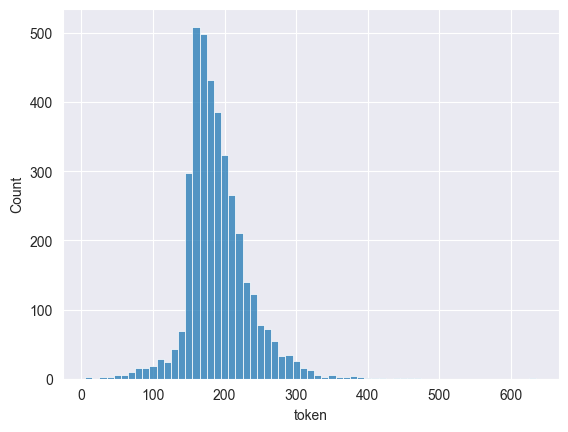

In [17]:
sns.histplot(d,x='token',binwidth=10)

## Tree kernel

if labels of $n_1$ and $n_2$ are the same:
$$
C(n_1,n_2) = 1 + \sum_{J_1,J_2,|J_1| = |J_2|}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}])
$$
we are summing over all pairs of possible subsequences of children of all possible length (smaller than shorter tree length), allowing partial trees with gaps   
With decay factors :
$$
C(n_1,n_2) = \mu (\lambda^2 + \sum_{J_1,J_2,|J_1| = |J_2|} \lambda^{(d(J_1)+d(J_2))}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}]))
$$
where
$$
d(J_1) = J_{1l(J_1)} - J_{1i} + 1
$$
if they are different:
$$
C(n_1,n_2) = 0
$$
The tree kernel of $T_1$ and $T_2$ is:
$$
K(T_1,T_2) = \sum_{t_1\in N_{T_1}}\sum_{t_2\in N_{T_2}}C(t_1,t_2)
$$
with normalization
$$
K_{norm}(T_1,T_2) = \dfrac{K(T_1,T_2)}{\sqrt{K(T_1,T_1) \times K(T_2,T_2)}}
$$

In [98]:
import math
def GetAllComb(n,NumList):
    # Get all subsets of length n in the given list, and in the original order
    res = []
    if n == 1: # [0,1,2] --> [[0],[1],[2]]
        return [[i] for i in NumList]
    if n == len(NumList): # [0,1,2] --> [0,1,2]
        return [[i for i in NumList]]
    if n >= 2: # for each element before len(NumList)-n, insert that element into position 0 for all subsets of length n-1 of the remaining elements
        for start in range(len(NumList)-n+1): 
            # (3,[0,1,2,3,4])
            last = GetAllComb(n-1,NumList[start+1:])
            # 0 + (2,[1,2,3,4]), 1 + (2,[2,3,4]), 2 + (2,[3,4])
            for comb in last:
                comb.insert(0,NumList[start])
            res += last
        return res
def KernelFunction(tree1,tree2,t1index,t2index,prev,tree1Index,tree2Index):
    # If already calculated, return result directly
    #print(t1index,t2index)
    if prev[t1index][t2index] != -1:
        return prev[t1index][t2index]
    # tree1 and tree2 are actually trees of token objects
    # get dep labels of all nodes, t1 and t2 are trees of dep labels
    t1 = (tree1[0].dep_,[i.dep_ for i in tree1[1] if i])
    t2 = (tree2[0].dep_,[i.dep_ for i in tree2[1] if i])
    # mu and lambda are decay factors, mu penalize tree height and lambda penalize tree length
    mu =0.9
    lambda_ = 0.9
    k = 0 # final sum
    if t1[0] == t2[0]: # if labels are the same
        max_tree_len = min(len(t1[1]),len(t2[1]))
        for tree_len in range(1,max_tree_len+1) :
            # length of all possible subtrees 
            #ChildSeqs = GetAllComb(tree_len,[c for c in range(min(len(t1[1]),len(t2[1])))])
            if max_tree_len <= 10:
                ChildSeqs = comb_dict[max_tree_len][tree_len]
            else:
                ChildSeqs = GetAllComb(tree_len,[c for c in range(max_tree_len)])
            #print(ChildSeqs)
            # list of indices of all possible child sequences of given length
            for j1 in ChildSeqs:
                for j2 in ChildSeqs:
                    # Get all pairs of sub sequences
                    #print(j1,j2)
                    prod = 1 # product
                    #print(len(j1),tree_len)
                    for i in range(tree_len):
                        childt1 = tree1[1][j1[i]] # token object
                        childt2 = tree2[1][j2[i]]
                        prodt1 = (childt1,[j for j in childt1.children if j.text.isalpha()]) # build subtree 
                        prodt2 = (childt2,[j for j in childt2.children if j.text.isalpha()])
                        #if prodt1[1] and prodt2[1]:
                        #print(prodt1,prodt2)
                        t1index = tree1Index[childt1]
                        t2index = tree2Index[childt2]
                        res = KernelFunction(prodt1,prodt2,t1index,t2index,prev,tree1Index,tree2Index) 
                        prod = prod * res
                        #if prev[t1index][t2index]  == -1:
                        prev[t1index][t2index] = res
                        #print(prod)
                        # continue matching subtree
                    # finish matching indices j1 and j2, sum 
                    dt1 = j1[-1] - j1[0] + 1
                    dt2 = j2[-1] - j2[0] + 1    
                    k += ((lambda_) ** (dt1 + dt2)) * prod
        return mu * (lambda_**2 + k)
    else:
        return 0
def PartialTreeKernel(tree1,tree2):
    prev = [[-1 for i in range(len(tree2))] for j in range(len(tree1))]
    tree1Index = {list(tree1)[i]:i for i in range(len(tree1))}
    tree2Index = {list(tree2)[i]:i for i in range(len(tree2))}
    sim = 0
    for tokent1 in tree1:
        prodt1 = (tokent1,[i for i in tokent1.children if i.text.isalpha()])
        for tokent2 in tree2:
            # sum over all nodes
            prodt2 = (tokent2,[i for i in tokent2.children if i.text.isalpha()])
            if tokent1.text.isalpha() and (tokent1.dep_ == tokent2.dep_):
                #print('subtree',prodt1,prodt2)
                t1index = tree1Index[tokent1]
                t2index = tree2Index[tokent2]
                res = KernelFunction(prodt1,prodt2,t1index,t2index,prev,tree1Index,tree2Index)
                sim += res
                prev[t1index][t2index] = res
    return sim 
def normPTK(tree1,tree2):
    return PartialTreeKernel(tree1,tree2)/math.sqrt(PartialTreeKernel(tree1,tree1)*PartialTreeKernel(tree2,tree2))

In [81]:
simnlp = spacy.load('en_core_web_sm')

In [119]:
doc1 = simnlp('I ate the orange that you gave me')
doc2 = simnlp('She refused the advice that he offered her')

In [120]:
normPTK(doc1,doc2)

1.0

In [121]:
doc1.similarity(doc2)

C:\Users\GIGA\AppData\Local\Temp\ipykernel_7772\2159000743.py:1: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  doc1.similarity(doc2)


0.8152315616607666

## VACs

In [19]:
s = '''
How to keep fit? It is an inevitable part in our life. My suggestion will be of some help. The key is to build up your vocabulary. A common problem is that we meet difficult vocabulary. Get up and go to bed early everyday. I found that it is better to see English as a language. It is the time we spend with our family that determine who we are. You want to make a new friend. We should continue listening for some time. They want their children to make friends with polite people. How to make their parents like us? The society sees many people trying to learn a foreign language. It makes our understanding disturbed. These simple things can make you healthier. My English teacher taught me that I have to read the passage. Your friends will invite you to visit their home. They teach you how to read. What he says may take me 15 minutes. We should keep our dormitory clean. Only in this way can we be good friends. We have been told the story. There are so many advantages. 
'''

In [23]:
GetVAC(s)

[('keep_adj', 3, 5),
 ('be_adj', 55, 57),
 ('be_noun(attr)', 7, 11),
 ('be_noun(attr)', 65, 68),
 ('be_noun(attr)', 192, 195),
 ('be_noun(attr)', 204, 208),
 ('be_prep', 18, 22),
 ('be_to_do', 25, 28),
 ('be_that', 35, 39),
 ('build_noun(dobj)', 27, 31),
 ('meet_noun(dobj)', 38, 41),
 ('see_noun(dobj)', 58, 60),
 ('make_noun(dobj)', 82, 86),
 ('make_noun(dobj)', 100, 102),
 ('like_noun(dobj)', 111, 113),
 ('learn_noun(dobj)', 121, 125),
 ('read_noun(dobj)', 149, 152),
 ('visit_noun(dobj)', 159, 162),
 ('tell_noun(dobj)', 199, 202),
 ('find_that(objcl)', 52, 56),
 ('determine_wh(objcl)', 74, 78),
 ('want_to_v2', 80, 83),
 ('try_to_v2', 119, 122),
 ('have_to_v2', 147, 150),
 ('continue_v2ing', 89, 91),
 ('keep_noun(dobj)_oprd', 181, 185),
 ('want_noun(subj)_to_v2', 96, 101),
 ('make_noun(subj)_v2', 108, 112),
 ('see_noun(subj)_v2ing', 116, 120),
 ('make_noun(subj)_v2ed', 127, 131),
 ('make_noun(subj)_adj', 136, 139),
 ('invite_noun(dobj)_to_v2', 156, 160),
 ('take_noun(dobj)_dative', 174

In [29]:
VACList = [('keep_adj', 3, 5),
 ('be_noun(attr)', 7, 11),
 ('be_noun(attr)', 192, 195),
 ('be_noun(attr)', 204, 208),
 ('be_prep', 18, 22),
 ('be_to_do', 25, 28),
 ('be_that', 35, 39),
 ('build_noun(dobj)', 27, 31),
 ('meet_noun(dobj)', 38, 41),
 ('see_noun(dobj)', 58, 60),
 ('make_noun(dobj)', 82, 86),
 ('make_noun(dobj)', 100, 102),
 ('like_noun(dobj)', 111, 113),
 ('learn_noun(dobj)', 121, 125),
 ('read_noun(dobj)', 149, 152),
 ('visit_noun(dobj)', 159, 162),
 ('tell_noun(dobj)', 199, 202),
 ('find_that(objcl)', 52, 56),
 ('determine_wh(objcl)', 74, 78),
 ('want_to_v2', 80, 83),
 ('try_to_v2', 119, 122),
 ('have_to_v2', 147, 150),
 ('continue_v2ing', 89, 91),
 ('keep_noun(dobj)_oprd', 181, 185),
 ('want_noun(subj)_to_v2', 96, 101),
 ('make_noun(subj)_v2', 108, 112),
 ('see_noun(subj)_v2ing', 116, 120),
 ('make_noun(subj)_v2ed', 127, 131),
 ('make_noun(subj)_adj', 136, 139),
 ('invite_noun(dobj)_to_v2', 156, 160),
 ('take_noun(dobj)_dative', 174, 178),
 ('teach_noun(dobj)_wh(cl)', 143, 148),
 ('teach_noun(dobj)_wh(cl)_to_v2', 164, 169),
 ('wh(objcl)_be_', 74, 78),
 ('relcl_spend_', 67, 70),
 ('wh(csubj)_say_', 170, 173),
 ('It_is_?_to_see_', 54, 59),
 ('passive_tell_', 198, 200),
 ('Only_prep_aux_be_inv', 186, 193),
 ('It_is_that/who_determine_', 64, 75),
 ('expl_be_', 203, 205),
 ('get_vi', 42, 43),
 ('go_vi_prep', 45, 48),
 ('listen_vi', 90, 91),
 ('disturb_vi', 130, 131),
 ('read_vi', 168, 169)]

In [30]:
doc = NLP(s)
doc.spans['sc'] = []
for vac in VACList:
    doc.spans['sc'].append(Span(doc,vac[1],vac[2],vac[0]))
displacy.serve(doc,style='span')


Using the 'span' visualizer
Serving on http://0.0.0.0:5000 ...



127.0.0.1 - - [15/May/2023 22:59:08] "GET / HTTP/1.1" 200 54754
127.0.0.1 - - [15/May/2023 22:59:08] "GET /favicon.ico HTTP/1.1" 200 54754


Shutting down server on port 5000.


## Dep tag list

In [6]:
t = '''ROOT, acl, acomp, advcl, advmod, agent, amod, appos, attr, aux, auxpass, case, cc, ccomp, compound, conj, csubj, csubjpass, dative, dep, det, dobj, expl, intj, mark, meta, neg, nmod, npadvmod, nsubj, nsubjpass, nummod, oprd, parataxis, pcomp, pobj, poss, preconj, predet, prep, prt, punct, quantmod, relcl, xcomp'''
for s in t.split(','):
    print(spacy.explain(s.strip()),', ',end='',sep='')


root, clausal modifier of noun (adjectival clause), adjectival complement, adverbial clause modifier, adverbial modifier, agent, adjectival modifier, appositional modifier, attribute, auxiliary, auxiliary (passive), case marking, coordinating conjunction, clausal complement, compound, conjunct, clausal subject, clausal subject (passive), dative, unclassified dependent, determiner, direct object, expletive, interjection, marker, meta modifier, negation modifier, modifier of nominal, noun phrase as adverbial modifier, nominal subject, nominal subject (passive), numeric modifier, object predicate, parataxis, complement of preposition, object of preposition, possession modifier, pre-correlative conjunction, None, prepositional modifier, particle, punctuation, modifier of quantifier, relative clause modifier, open clausal complement, 

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\glossary.py:19: UserWarning: [W118] Term 'predet' not found in glossary. It may however be explained in documentation for the corpora used to train the language. Please check `nlp.meta["sources"]` for any relevant links.
  warnings.warn(Warnings.W118.format(term=term))


In [7]:
len(t.split(','))

45

In [5]:
t = '''NOUN, VERB, PRPON, INTJ, ADJ, ADV, ADP, AUX, CCONJ, DET, NUM, PART, PRON, SCONJ'''
for s in t.split(','):
    print(spacy.explain(s.strip()),', ',end='',sep='')

noun, verb, None, interjection, adjective, adverb, adposition, auxiliary, coordinating conjunction, determiner, numeral, particle, pronoun, subordinating conjunction, 

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\glossary.py:19: UserWarning: [W118] Term 'PRPON' not found in glossary. It may however be explained in documentation for the corpora used to train the language. Please check `nlp.meta["sources"]` for any relevant links.
  warnings.warn(Warnings.W118.format(term=term))
